# Image Recognation Project Dataset

The dataset is collected by the previous code. Please save the collected data (zip file or folder) in the same directory of this code in google drive.

The dataset consists of XX <b> 480x640x3</b> color images in 3 classes (scissors, rock and paper).


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:

## Look at the current directory
%ls

 2022_project_template.ipynb
 data_prep.ipynb
 dlutils.py
'ImageRecog NN Model template for instructors.ipynb'
'ImageRecog NN Model template for students.ipynb'
 img/
 kerutils.py
'NN team project presentation template for students.pptx'
 pt1_Weight_Initialization.ipynb
 pt3_Neural_Network_Example_CIFAR-10.ipynb
 README.md
 rps.zip
'Team project for NN.pptx'


In [5]:
## Change the current dire
#%cd 'gdrive/My Drive/CIFAR_Image_Recognition'
%cd 'gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition'

/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition


# Import Data

In [8]:
!unzip -o rps.zip # use this only when you use zip files or just skip this step

Archive:  rps.zip
  inflating: rps/scissors/scissors_3.jpg  
  inflating: rps/scissors/scissors_8.jpg  
  inflating: rps/paper/paper_9.jpg   
  inflating: rps/scissors/scissors_9.jpg  
  inflating: rps/scissors/scissors_2.jpg  
  inflating: rps/scissors/scissors_7.jpg  
  inflating: rps/scissors/scissors_10.jpg  
  inflating: rps/scissors/scissors_11.jpg  
  inflating: rps/paper/paper_5.jpg   
  inflating: rps/scissors/scissors_1.jpg  
  inflating: rps/paper/paper_1.jpg   
  inflating: rps/scissors/scissors_6.jpg  
  inflating: rps/paper/paper_2.jpg   
  inflating: rps/paper/paper_10.jpg  
  inflating: rps/paper/paper_6.jpg   
  inflating: rps/paper/paper_7.jpg   
  inflating: rps/paper/paper_8.jpg   
  inflating: rps/paper/paper_4.jpg   
  inflating: rps/paper/paper_3.jpg   
  inflating: rps/rock/rock_3.jpg     
  inflating: rps/rock/rock_2.jpg     
  inflating: rps/rock/rock_4.jpg     
  inflating: rps/rock/rock_1.jpg     
  inflating: rps/rock/rock_5.jpg     
  inflating: rps/scisso

In [126]:
import cv2
import glob

X_scissor = np.asarray([cv2.imread(file) for file in glob.glob('rps/scissors/*.jpg')])
y_scissor = np.zeros(X_scissor.shape[0])
X_rock = np.asarray([cv2.imread(file) for file in glob.glob('rps/rock/*.jpg')])
y_rock = np.zeros(X_rock.shape[0]) + 1
X_paper = np.asarray([cv2.imread(file) for file in glob.glob('rps/paper/*.jpg')])
y_paper = np.zeros(X_paper.shape[0]) + 2

X_all = np.concatenate((X_scissor, X_rock, X_paper), axis=0)
y_all = np.concatenate((y_scissor, y_rock, y_paper), axis=0)

X_all.shape

(23, 480, 640, 3)

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)

(18, 480, 640, 3)
(5, 480, 640, 3)


# Import Packages

In [93]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
# from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.layers.noise import GaussianNoise
#from keras.layers.advanced_activations import SReLU
#from keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
import os, sys, time, datetime, fnmatch
import numpy as np
import dlutils
import kerutils
from dlutils import *
from kerutils import *

Define classes

In [128]:
nb_classes = 3
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}

Loading Training and test data

The original data of each image is a 480x640x3 matrix of integers from 0 to 255. We need to scale it down to floats in the unit interval

In [129]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

As usual, we must convert the y_train and y_test vectors to one-hot format:<br>
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]<br>

In [130]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Let's also write two small utilities for drawing samples of images, so we can inspect our results visually.

In [131]:
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(480,640,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

Let's draw an image in X_train for example

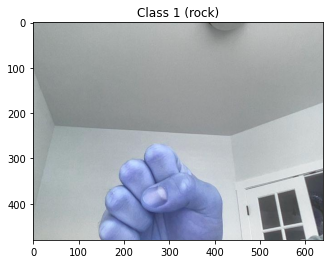

In [132]:
draw_img(0)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

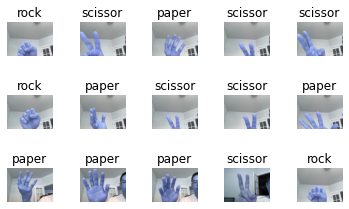

In [133]:
draw_sample(X_train, y_train, 0,3,5)

# Building Neural Network for the image set

The input layer would have to be of size 480x640x3. If we add a hidden layer with the same size, we'll end up with 9 milion synapses on the first floor. Adding one more layer of such size will take us to billions of synapses, which is of course impractical.<br>
Deep learning frameworks have come up with special types of designated layers for processing images. Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than pixels in a far away region of the image.<br>
We will start with a small Keras model which combines a well thought mix of <b>Convolution2D</b>, <b>Maxpooling2D</b> and Dense layers.<br>


We will use two types of training:<br>
<b>Standard training</b>: the usual Keras fit method<br>



# Let's Train Model 

Try another architecture

In [134]:
nb_epoch = 10
batch_size = 4

model1 = Sequential()
model1.add(Convolution2D(4, 2, 2, input_shape=(480, 640, 3), activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters 
model1.add(Convolution2D(8, 2, 2, activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters 
model1.add(Flatten())
model1.add(Dense(32, activation='relu')) # add parameters and activation function
model1.add(Dense(nb_classes, activation='softmax')) # activation function
# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)

# save the model if it's needed
# print('Saving model1 to the file "model_1.h5"')
# model1.save("model_1.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 240, 320, 4)       52        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 160, 4)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 80, 8)         136       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 40, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9600)              0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [135]:
def show_scores1(model, h, X_train, Y_train, X_test, Y_test):
    loss, acc = model.evaluate(X_train, Y_train, verbose=0)
    print ("Training: accuracy   = %.6f loss = %.6f" % (acc, loss))
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print ("Validation: accuracy = %.6f loss = %.6f" % (acc, loss))
    if 'val_acc' in h.history:
        print ("Over fitting score   = %.6f" % over_fitting_score(h))
        print ("Under fitting score  = %.6f" % under_fitting_score(h))
    print ("Params count:", model.count_params())
    print ("stop epoch =", max(h.epoch))
    print ("nb_epoch =", h.params['epochs'])
    #print ("batch_size =", h.params['batch_size'])
    #print ("nb_sample =", h.params['samples'])
    view_acc1(h)
    id = model.name[-1]
    plt.savefig(model.name + '_acc_graph.png')
    plt.show()
    view_loss(h)
    plt.savefig(model.name + '_loss_graph.png')
    plt.show()


In [136]:
def view_acc1(h):
    # Accuracy history graph
    plt.plot(h.history['accuracy'])
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)


Training: accuracy   = 0.555556 loss = 0.951180
Validation: accuracy = 0.600000 loss = 1.112585
Params count: 307519
stop epoch = 9
nb_epoch = 10


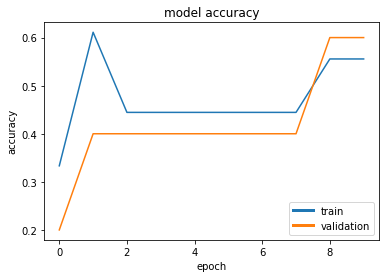

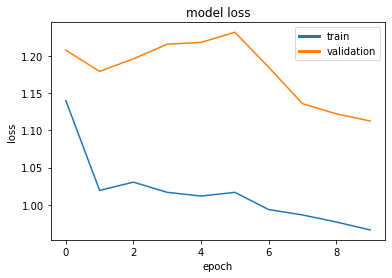

In [138]:
show_scores1(model1, h, X_train, Y_train, X_test, Y_test)

In [ ]:
# model1 = load_model("model_1.h5")

In [139]:
loss, accuracy = model1.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Training: accuracy = 0.555556  ;  loss = 0.951180
Validation: accuracy1 = 0.600000  ;  loss1 = 1.112585


# Inspecting Output

Neverthelss, befor we search for a new model, let's take a quick look on some of the cases that our model1 missed. It may give us hints on the strengths an weaknesses of NN models, and what we can expect from these artificial models.<br>
The predict_classes method is helpful for getting a vector (y_pred) of the predicted classes of model1. We should compare y_pred to the expected true classes y_test in order to get the false cases:

In [143]:
predict_x=model1.predict(X_test) 
y_pred =np.argmax(predict_x,axis=1)
true_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

Number of true predictions:  3
Number of false predictions: 2


Let's see images we can recognize

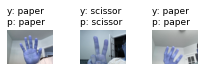

In [144]:
for i,(x,y,p) in enumerate(true_preds[0:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

Let's see iamges we can not recognize.

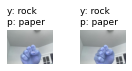

In [145]:
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)